In [1]:
import sys
import numpy as np
np.set_printoptions(suppress=True)
# np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from itertools import zip_longest
from sklearn.utils import shuffle
from sklearn.datasets import load_digits
import random
import pandas as pd

In [2]:
SEED = 8
random.seed(SEED)
def shuffle_forward(l):
    order = list(range(len(l)))
    random.shuffle(order)
    return np.array(np.array(l)[order]), order

def shuffle_backward(l, order):
    l_out = [0] * len(l)
    for i, j in enumerate(order):
        l_out[j] = l[i]
    return l_out

In [3]:
class SingleLayerSNN:
    def __init__(
        self,
        inputs,
        weights,
        trainings,
        Cm=4.0,
        Rm=5.0,
        V_thresh=30.0,
        V_rest=-65.0,
        V_spike=80.0,
        dT=0.01,
        rate=1.0,
    ):
        """
        Runs a LIF simulation on neuron and returns outputted voltage

                Parameters:
                        inputs (double[][][]): A 3d numpy array of the input voltages per timestep
                        weights (double[]): A numpy array of initial weights
                        outputs (double[][][]): A 3d numpy array of the output voltages per timestep used for teaching neuron
                Returns:
                        None
        """

        assert len(trainings) == len(inputs)

        self.inputs = inputs
        self.weights = weights
        self.trainings = trainings
        self.Cm = Cm
        self.Rm = Rm
        self.V_thresh = V_thresh
        self.V_rest = V_rest
        self.V_spike = V_spike
        self.dT = dT  # ms
        self.rate = rate  # sec
        self._LIF_spikes = 0

    def LIF(self, I):
        """
        Runs a LIF simulation on neuron and returns outputted voltage

                Parameters:
                        I (double[]): A numpy array of input voltages in mV

                Returns:
                        V (double[]): A numpy array of the output voltages in mV
        """
        total_time = (I.size) * self.dT

        # an array of time
        time = np.arange(0, total_time, self.dT)

        # default voltage list set to resting volatage of -65mV
        V = (self.V_rest) * np.ones(len(time))

        did_spike = False

        # function member variable to track spikes
        self._LIF_spikes = 0

        for t in range(len(time)):
            # using "I - V(t)/Rm = Cm * dV/dT"
            dV = (I[t] - (V[t - 1] - self.V_rest) / self.Rm) / self.Cm

            # reset membrane potential if neuron spiked last tick
            if did_spike:
                V[t] = self.V_rest + dV * self.dT
            else:
                V[t] = V[t - 1] + dV * self.dT

            # check if membrane voltage exceeded threshold (spike)
            if V[t] > self.V_thresh:
                did_spike = True
                # set the last step to spike value
                V[t] = self.V_spike
                self._LIF_spikes += 1
            else:
                did_spike = False

        return V

    def voltage_to_output(self, V_input):
        """Converts a neuron's internal voltage to output"""
        V_output = np.zeros(V_input.shape)
        for i, v in enumerate(V_input):
            V_output[i] = 0 if v < self.V_spike else self.V_spike
        return V_output

    def voltage_to_spike_rate(self, voltages, dT=None, rate=None):
        """Converts an array of neuron voltages to spikes per n seconds, where n = rate"""
        if not dT:
            dT = self.dT
        if not rate:
            rate = self.rate

        #         print('voltages', voltages)

        def cond(V):
            return V >= self.V_spike

        spike_count = sum(cond(V) for V in voltages)

        #         print('spike_count', spike_count)

        total_time_dT = len(voltages) * dT
        #         print(f'total_time_dT: {total_time_dT} ({dT}ms)')

        spikes_per_dT = spike_count / total_time_dT
        #         print(f'spikes_per_ms: {spikes_per_dT} (spikes/ms)')

        return spikes_per_dT * 1000 * rate

    # returns the voltages of input and output neurons
    def feed_forward(self, inputs, train=True):
        """
        Passes all sets of inputs to 

                Parameters:
                        inputs (double[][][]): A 3d numpy array that contains every set of inputs voltages for each input neuron
                        train (boolean): Determines whether or not to inject training voltages

                Returns:
                        all_input_voltages, all_output_voltages (double[][][], double[][][]): A tuple of all of the input voltages and all of the output voltages
        """
        all_input_voltages = []
        all_output_voltages = []

        # set the training voltages to all zero if not running in training mode
        training_copy = (
            np.zeros(inputs.shape, np.ndarray)
            if not train
            else np.array(self.trainings)
        )
        #         print('training_copy:')
        #         print(training_copy)

        inputs_copy = np.array(inputs)
        #         print('inputs_copy:')
        #         print(inputs_copy)

        assert len(training_copy) == len(inputs_copy)

        zipped = list(zip(inputs_copy, training_copy))

        shuffled, order = shuffle_forward(zipped)
        shuffled_inputs, shuffled_trainings = zip(*shuffled)

        shuffled_inputs = np.array(shuffled_inputs)
        #         print('shuffled_inputs:')
        #         print(shuffled_inputs)

        shuffled_trainings = np.array(shuffled_trainings)
        #         print('shuffled_trainings:')
        #         print(shuffled_trainings)
        
        # feed inputs through input neurons to get weighted voltage for output neurons
        for input_set, training_set in zip_longest(shuffled_inputs, shuffled_trainings):
            input_voltages = []
            for V_input in input_set:
                input_voltages.append(self.LIF(V_input))

            output_inputs = []
            input_outputs = []  # DEBUG ONLY
            for weight_set in self.weights.T:
                weighted_sum = np.zeros(len(input_set[0]))
                for V_input, weight in zip(input_voltages, weight_set):
                    # filter for spikes b/c a neuron only outputs if it spikes
                    input_output = self.voltage_to_output(V_input)
                    input_outputs.append(input_output)  # DEBUG ONLY
                    weighted = input_output * weight
                    weighted_sum = np.add(weighted_sum, weighted)

                output_inputs.append(weighted_sum)

            input_voltages = np.array(input_voltages)
            input_outputs = np.array(input_outputs)
            output_inputs = np.array(output_inputs)

            #             print('input_voltages:')
            #             print(input_voltages)
            #             print('input_outputs:')
            #             print(input_outputs)
            #             print('output_inputs:')
            #             print(output_inputs)
            #             print('training_set:')
            #             print(training_set)

            all_input_voltages.append(input_voltages)

            # inject training voltage if in training mode
            assert isinstance(training_set, (list, np.ndarray))
            for i, (output_input, training_input) in enumerate(
                zip(output_inputs, training_set)
            ):
                assert isinstance(training_input, (list, np.ndarray))
                #               padded_training_input = np.pad(training_input, (0, len(output_inputs) - len(training_set)), "constant")
                output_inputs[i] = output_input + training_input

            #             print('output_inputs after injecting training current')
            #             print(output_inputs)

            # run LIF on output neurons
            output_voltages = []
            for V_input in output_inputs:
                output_voltages.append(self.LIF(V_input))

            output_voltages = np.array(output_voltages)
            all_output_voltages.append(output_voltages)

        #             print('output_voltages:')
        #             print(output_voltages)

        # unshuffle the voltages
        all_input_voltages = np.array(shuffle_backward(all_input_voltages, order))
        all_output_voltages = np.array(shuffle_backward(all_output_voltages, order))

        return all_input_voltages, all_output_voltages

    def train(self, epochs=75, a_corr=0.000000002, w_max=2, w_decay=0, show_legend=True):
        """Runs feed forward with training dataset"""
        weights_history = []
        for weight_set in self.weights:
            weight_row = []
            for weight in weight_set:
                weight_row.append([weight])
            weights_history.append(weight_row)

        for epoch in range(epochs):
            print(f"Epoch: {epoch + 1}")
            
            print('\trunning feed forward...')
            all_input_voltages, all_output_voltages = self.feed_forward(
                self.inputs, train=True
            )

            # debug info
            #             print()
            #             print('------------------------------------------------')
            #             print('all_input_voltages:')
            #             print(all_input_voltages)
            #             print('all_output_voltages:')
            #             print(all_output_voltages)

            #             print('weights:')
            #             print(self.weights)
            
            print('\tapplying learning rule...')
            # apply learning rule
            for input_voltages, output_voltages in zip(
                all_input_voltages, all_output_voltages
            ):
#                 print('input_voltages:')
#                 print(input_voltages)
                for i, (input_voltage_set, weight_set) in enumerate(
                    zip(input_voltages, self.weights)
                ):
#                     print('input_voltage_set', input_voltage_set)
                    input_rate = self.voltage_to_spike_rate(input_voltage_set)
#                     print(f'input_rate {i}:', input_rate)

                    for j, (output_voltage_set, weight) in enumerate(
                        zip(output_voltages, weight_set)
                    ):
                        output_rate = self.voltage_to_spike_rate(output_voltage_set)
#                         print(f'\toutput_rate {j}:', output_rate)

                        # adjust the weight using Hebb with decay
                        weight_change = a_corr * input_rate * output_rate - w_decay
#                         print('\told weight', weight)
#                         print('\tweight_change:', weight_change)

                        if weight + weight_change < 0:
                            self.weights[i][j] = 0
                        elif weight + weight_change > w_max:
                            self.weights[i][j] = w_max
                        else:
                            self.weights[i][j] = weight + weight_change

#                         print('\tnew weight', self.weights[i][j], '\n')

            # update weight history
            for i, weight_set in enumerate(self.weights):
                for j, weight in enumerate(weight_set):
                    weights_history[i][j].append(weight)
            
            print('\tweights:')
            print('\t' + str(self.weights).replace('\n','\n\t'))

        # plot neuron spiking data
        #             for i, (input_voltages, output_voltages) in enumerate(zip(all_input_voltages, all_output_voltages)):
        #                 plt.figure(figsize=(20,10))
        #                 plt.title(f'Input: {i + 1}')
        #                 for input_voltage in input_voltages:
        #                     plt.plot(input_voltage, 'b:', alpha=.5)

        #                 for output_voltage in output_voltages:
        #                     plt.plot(output_voltage, 'r--', alpha=.5)

        #             plt.show()

        # plot weights history
        plt.figure(figsize=(20, 10))
        for i, weight_row in enumerate(weights_history):
            for j, weight_history in enumerate(weight_row):
                plt.plot(weight_history, label=f"weight {i}-{j}")
        if show_legend:
            plt.legend(loc="upper left")
        plt.title("Weight History")
        plt.show()
        
    def _generate_bar_plot(self, outputs, title='', ylabel='', stacked=False):
        d = {}
        '''Generates bar plot for output neuron data'''
        for x, bars in enumerate(outputs.T):
            d[f'Output Neuron {x}'] = bars
        index = [f'{x}' for x in range(len(outputs.T[0]))]
        df = pd.DataFrame(d, index=index)
        ax = df.plot.bar(rot=0, figsize=(20, 10), stacked=stacked, title=title)
        ax.set_xlabel('Input Set')
        ax.set_ylabel(ylabel)

    def predict(self, inputs, bar_width=0.25):
        """Runs feed foward without training data on inputs"""
        all_input_voltages, all_output_voltages = self.feed_forward(inputs, train=False)
#         print('all_output_voltages')
#         print(all_output_voltages)

        all_output_confidences = []
        all_output_spike_rates = []

        for x, (input_voltages, output_voltages) in enumerate(
            zip(all_input_voltages, all_output_voltages)
        ):
            output_spike_rates = []
            output_confidences = []
            print("input set:", x)
            for i, input_voltage_set in enumerate(input_voltages):
                print(
                    f"\tinput {i}: {self.voltage_to_spike_rate(input_voltage_set)} spikes/{self.rate}s"
                )
            print()

            output_voltages_sum = sum(
                [self.voltage_to_spike_rate(v) for v in output_voltages]
            )
            for i, output_voltage_set in enumerate(output_voltages):
                sr = self.voltage_to_spike_rate(output_voltage_set)
                output_spike_rates.append(sr)
                confidence = (
                    "N/A" if output_voltages_sum == 0 else sr / output_voltages_sum
                )
                output_confidences.append(0 if confidence == "N/A" else confidence)
                print(
                    f"\toutput {i}: {sr} spikes/{self.rate}s, confidence: {confidence}"
                )
            print()
            all_output_spike_rates.append(output_spike_rates)
            all_output_confidences.append(output_confidences)

        all_output_confidences = np.array(all_output_confidences)
        all_output_spike_rates = np.array(all_output_spike_rates)

        #         print(all_output_confidences)
        #         print(all_output_spike_rates)

        # plot output confidence
        self._generate_bar_plot(all_output_confidences, title="Output Confidence", ylabel="Confidence", stacked=True,)
        # plot output spike rates
        self._generate_bar_plot(
            all_output_spike_rates,
            ylabel=f"Spike Rate (spikes/{self.rate}s)",
            title="Output Spike Rates",

        )
        return all_input_voltages, all_output_voltages


# Logical AND

In [4]:
u_t = 2000  # units of time
i_a = 1000.0  # input amount

# NOTE: we want the same number of training inputs for each output class
inputs = np.array(
    [
        [[i_a] * u_t, [0.0] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[i_a] * u_t, [0.0] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[i_a] * u_t, [0.0] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[i_a] * u_t, [0.0] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: T, y: F --> F
        [[0.0] * u_t, [i_a] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: F, y: T --> F
        [[0.0] * u_t, [i_a] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: F, y: F --> F
    ]
)

t_a = 1000.0  # training amount
s_a = -100.0  # supress amount

# current that gets injected to the output neurons
trainings = np.array(
    [
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[s_a] * u_t, [t_a] * u_t],  # F
        [[s_a] * u_t, [t_a] * u_t],  # F
        [[s_a] * u_t, [t_a] * u_t],  # F
    ]
)

# initiate the weights to be half of max weight
weights = np.array(
    [
        [0.0, 0.0],
        [0.0, 0.0],
        [0.0, 0.0],
        [0.0, 0.0],
    ]
)

and_network = SingleLayerSNN(inputs=inputs, weights=weights, trainings=trainings)

# BEST PARAMS FOR AND NETWORK: epochs=77, a_corr=0.000000002, w_max=2.0, w_decay=0.0001
# and_network.train(epochs=77, a_corr=0.000000002, w_max=2.0, w_decay=0.0001)

p_a = 10000.0  # predict input amount

# the four possible cases
predict_inputs = np.array(
    [
        [[p_a] * u_t, [0.0] * u_t, [p_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[p_a] * u_t, [0.0] * u_t, [0.0] * u_t, [p_a] * u_t],  # x: T, y: F --> F
        [[0.0] * u_t, [p_a] * u_t, [p_a] * u_t, [0.0] * u_t],  # x: F, y: T --> F
        [[0.0] * u_t, [p_a] * u_t, [0.0] * u_t, [p_a] * u_t],  # x: F, y: F --> F
    ]
)
# and_network.predict(predict_inputs)


# Logical OR

Epoch: 1
	running feed forward...
	applying learning rule...
	weights:
	[[0.12999  0.      ]
	 [0.064985 0.195045]
	 [0.12999  0.      ]
	 [0.064975 0.195045]]
Epoch: 2
	running feed forward...
	applying learning rule...
	weights:
	[[0.25998 0.     ]
	 [0.12995 0.39006]
	 [0.25998 0.     ]
	 [0.12994 0.39006]]
Epoch: 3
	running feed forward...
	applying learning rule...
	weights:
	[[0.38997  0.      ]
	 [0.194915 0.585075]
	 [0.38997  0.      ]
	 [0.194905 0.585075]]
Epoch: 4
	running feed forward...
	applying learning rule...
	weights:
	[[0.51996 0.     ]
	 [0.25988 0.78009]
	 [0.51996 0.     ]
	 [0.25987 0.78009]]
Epoch: 5
	running feed forward...
	applying learning rule...
	weights:
	[[0.64995  0.      ]
	 [0.324845 0.975105]
	 [0.64995  0.      ]
	 [0.324835 0.975105]]
Epoch: 6
	running feed forward...
	applying learning rule...
	weights:
	[[0.77994 0.     ]
	 [0.38981 1.17012]
	 [0.77994 0.     ]
	 [0.3898  1.17012]]
Epoch: 7
	running feed forward...
	applying learning rule...
	we

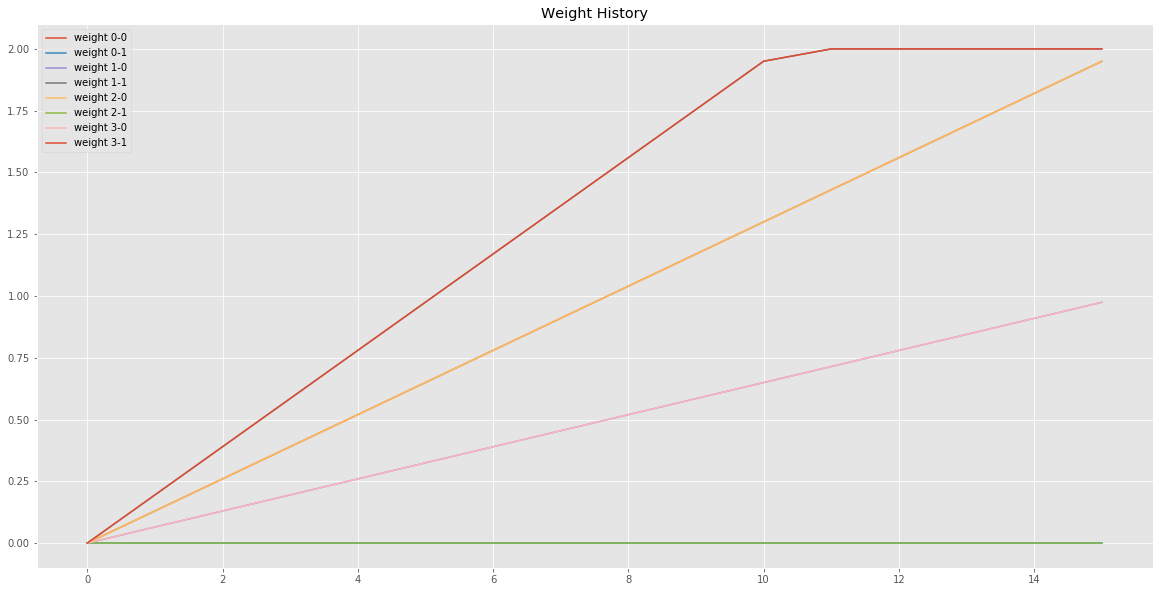

input set: 0
	input 0: 100000.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 100000.0 spikes/1.0s
	input 3: 0.0 spikes/1.0s

	output 0: 750.0 spikes/1.0s, confidence: 1.0
	output 1: 0.0 spikes/1.0s, confidence: 0.0

input set: 1
	input 0: 100000.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 0.0 spikes/1.0s
	input 3: 100000.0 spikes/1.0s

	output 0: 550.0 spikes/1.0s, confidence: 0.6111111111111112
	output 1: 350.0 spikes/1.0s, confidence: 0.3888888888888889

input set: 2
	input 0: 0.0 spikes/1.0s
	input 1: 100000.0 spikes/1.0s
	input 2: 100000.0 spikes/1.0s
	input 3: 0.0 spikes/1.0s

	output 0: 550.0 spikes/1.0s, confidence: 0.6111111111111112
	output 1: 350.0 spikes/1.0s, confidence: 0.3888888888888889

input set: 3
	input 0: 0.0 spikes/1.0s
	input 1: 100000.0 spikes/1.0s
	input 2: 0.0 spikes/1.0s
	input 3: 100000.0 spikes/1.0s

	output 0: 350.0 spikes/1.0s, confidence: 0.30434782608695654
	output 1: 800.0 spikes/1.0s, confidence: 0.6956521739130435



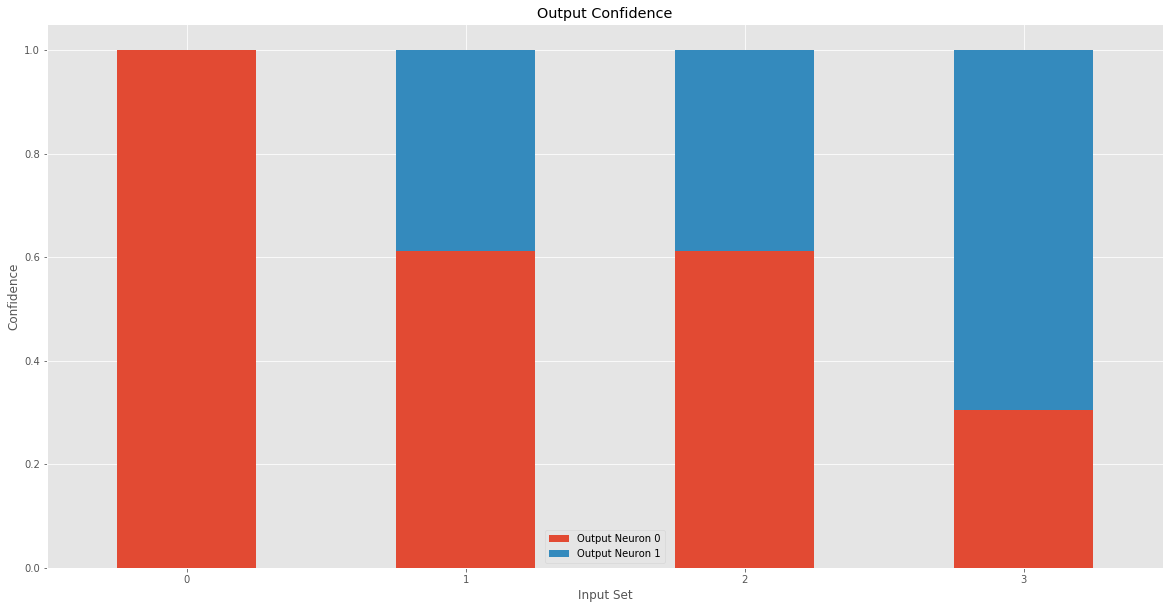

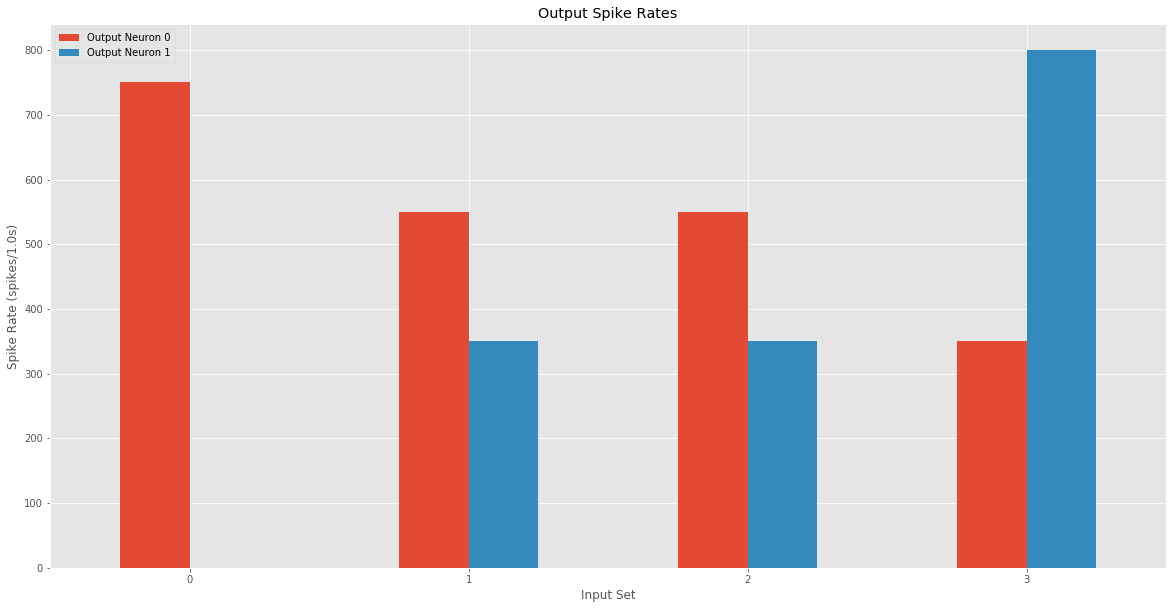

In [5]:
u_t = 2000  # units of time
i_a = 1000.0  # input amount

# NOTE: we want the same number of training inputs for each output class
inputs = np.array(
    [
        [[i_a] * u_t, [0.0] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[i_a] * u_t, [0.0] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: T, y: F --> T
        [[0.0] * u_t, [i_a] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: F, y: T --> T
        [[0.0] * u_t, [i_a] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: F, y: F --> F
        [[0.0] * u_t, [i_a] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: F, y: F --> F
        [[0.0] * u_t, [i_a] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: F, y: F --> F

    ]
)

t_a = 1000.0  # training amount
s_a = -100.0  # supress amount

# current that gets injected to the output neurons
trainings = np.array(
    [
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[s_a] * u_t, [t_a] * u_t],  # F
        [[s_a] * u_t, [t_a] * u_t],  # F
        [[s_a] * u_t, [t_a] * u_t],  # F
    ]
)

# initiate the weights to be half of max weight
weights = np.array(
    [
        [0.0, 0.0],
        [0.0, 0.0],
        [0.0, 0.0],
        [0.0, 0.0],
    ]
)

or_network = SingleLayerSNN(inputs=inputs, weights=weights, trainings=trainings)

# BEST PARAMS FOR OR NETWORK: epochs=15, a_corr=0.00000001, w_max=2.0, w_decay=0.00001
# or_network.train(epochs=15, a_corr=0.00000001, w_max=2.0, w_decay=0.00001)

p_a = 100000.0  # predict input amount

# the four possible cases
predict_inputs = np.array(
    [
        [[p_a] * u_t, [0.0] * u_t, [p_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[p_a] * u_t, [0.0] * u_t, [0.0] * u_t, [p_a] * u_t],  # x: T, y: F --> T
        [[0.0] * u_t, [p_a] * u_t, [p_a] * u_t, [0.0] * u_t],  # x: F, y: T --> T
        [[0.0] * u_t, [p_a] * u_t, [0.0] * u_t, [p_a] * u_t],  # x: F, y: F --> F
    ]
)
# or_network.predict(predict_inputs);


# Digit Classification

Epoch: 1
	running feed forward...
	applying learning rule...
	weights:
	[[0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.0159375 0.        0.        0.0230775 0.        0.0363375 0.
	  0.0230775 0.028305  0.0363375]
	 [0.0424575 0.0363375 0.01275   0.0424575 0.0031875 0.031875  0.0363375
	  0.0255    0.0424575 0.0363375]
	 [0.028305  0.0424575 0.0424575 0.0424575 0.0363375 0.        0.0424575
	  0.0424575 0.0255    0.       ]
	 [0.0031875 0.0159375 0.0363375 0.0031875 0.        0.        0.
	  0.051     0.0031875 0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.0424575 0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.0031875 0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.        0.

	applying learning rule...
	weights:
	[[0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.048125  0.        0.        0.069685  0.        0.1104375 0.
	  0.069685  0.086025  0.1104375]
	 [0.128205  0.1104375 0.03875   0.128205  0.009625  0.096875  0.1104375
	  0.077     0.1290375 0.1104375]
	 [0.08547   0.1290375 0.1290375 0.128205  0.109725  0.        0.1290375
	  0.128205  0.0775    0.       ]
	 [0.009625  0.0484375 0.1104375 0.009625  0.        0.        0.
	  0.154     0.0096875 0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.128205  0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.009625  0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.        0.        0.        0.077     0.    

	applying learning rule...
	weights:
	[[0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.0809375 0.        0.        0.116745  0.        0.1873875 0.
	  0.11765   0.145965  0.1873875]
	 [0.2156175 0.1873875 0.06575   0.214785  0.0161875 0.164375  0.186675
	  0.13      0.2189475 0.1873875]
	 [0.143745  0.2189475 0.2189475 0.214785  0.1845375 0.        0.218115
	  0.21645   0.1315    0.       ]
	 [0.0161875 0.0821875 0.1873875 0.016125  0.        0.        0.
	  0.26      0.0164375 0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.21645   0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.01625   0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.        0.        0.        0.129     0.      

	applying learning rule...
	weights:
	[[0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.1146875 0.        0.        0.165615  0.        0.2657625 0.
	  0.16652   0.207015  0.26505  ]
	 [0.3055275 0.2657625 0.09325   0.304695  0.0229375 0.233125  0.2643375
	  0.184     0.3105225 0.26505  ]
	 [0.203685  0.3105225 0.3105225 0.304695  0.2614875 0.        0.3088575
	  0.30636   0.1865    0.       ]
	 [0.0229375 0.1165625 0.2657625 0.022875  0.        0.        0.
	  0.368     0.0233125 0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.30636   0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.023     0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.        0.        0.        0.183     0.    

	applying learning rule...
	weights:
	[[0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.1490625 0.        0.        0.2149375 0.        0.3469875 0.
	  0.216295  0.269175  0.34485  ]
	 [0.3971025 0.3455625 0.12125   0.3954375 0.0298125 0.304375  0.3427125
	  0.239     0.4037625 0.34485  ]
	 [0.264735  0.4037625 0.4037625 0.3954375 0.3398625 0.        0.4004325
	  0.397935  0.2425    0.       ]
	 [0.0298125 0.1515625 0.3455625 0.0296875 0.        0.        0.
	  0.478     0.0303125 0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.397935  0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.029875  0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.        0.        0.        0.2375    0.    

	applying learning rule...
	weights:
	[[0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.1834375 0.        0.        0.2647125 0.        0.428925  0.
	  0.266975  0.333     0.4267875]
	 [0.4886775 0.4275    0.15      0.4870125 0.0366875 0.37625   0.4239375
	  0.295     0.4995    0.4267875]
	 [0.325785  0.4995    0.4995    0.4870125 0.4182375 0.        0.4953375
	  0.491175  0.3       0.       ]
	 [0.0366875 0.1875    0.4275    0.0365625 0.        0.        0.
	  0.59      0.0375    0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.491175  0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.036875  0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.        0.        0.        0.2925    0.    

	applying learning rule...
	weights:
	[[0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.2190625 0.0007125 0.000555  0.3153925 0.        0.5176725 0.
	  0.31856   0.4011825 0.513555 ]
	 [0.5835825 0.513875  0.181295  0.5802525 0.0438125 0.455765  0.5073
	  0.352     0.60078   0.51357  ]
	 [0.389055  0.6002325 0.5999    0.5802525 0.4994625 0.0018325 0.59274
	  0.58608   0.3603325 0.0005   ]
	 [0.0438125 0.2254    0.5126625 0.0435625 0.        0.0004375 0.
	  0.704     0.04565   0.0000625]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.58608   0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.044     0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.        0.        0.        0.3485    0.        0

	applying learning rule...
	weights:
	[[0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.255     0.0052275 0.0042    0.368855  0.        0.61403   0.0023775
	  0.37105   0.475045  0.60602  ]
	 [0.67932   0.6090225 0.22145   0.67724   0.051     0.5475075 0.5986225
	  0.41      0.713715  0.607825 ]
	 [0.45288   0.709125  0.7092925 0.67599   0.5814    0.0115475 0.699015
	  0.68265   0.43049   0.00422  ]
	 [0.051     0.2665625 0.6010875 0.05075   0.        0.00265   0.00255
	  0.82      0.057125  0.0013375]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.68265   0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.05125   0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.        0.0001275 0.0001275 0.406

	applying learning rule...
	weights:
	[[0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.2955225 0.0157725 0.0139775 0.42647   0.        0.719125  0.0094275
	  0.4248975 0.5591225 0.7072225]
	 [0.7810625 0.71645   0.2727775 0.7802325 0.06045   0.65731   0.6993475
	  0.4704625 0.8443675 0.7175275]
	 [0.518815  0.8304325 0.8292225 0.775225  0.66726   0.03674   0.814375
	  0.7833825 0.5141825 0.0185425]
	 [0.0584375 0.31205   0.694775  0.0585    0.0003125 0.0094625 0.0079875
	  0.940025  0.072925  0.0051625]
	 [0.        0.0008325 0.001665  0.        0.        0.        0.
	  0.7817175 0.0008325 0.       ]
	 [0.        0.0000625 0.000125  0.        0.        0.        0.
	  0.0586875 0.0000625 0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.000255  0.00151   0.00051   0.4

	applying learning rule...
	weights:
	[[0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.3423675 0.03624   0.0341625 0.4902175 0.002535  0.836365  0.024955
	  0.48102   0.655225  0.8177225]
	 [0.8919425 0.8428175 0.3448975 0.8937875 0.077065  0.7870525 0.81744
	  0.5357275 0.9972025 0.8446775]
	 [0.58908   0.9708625 0.9692275 0.8817875 0.762085  0.076735  0.9450925
	  0.8892775 0.6186625 0.04861  ]
	 [0.0669    0.3653875 0.7968375 0.0679    0.0028    0.020075  0.017375
	  1.063225  0.0965125 0.014875 ]
	 [0.        0.0041625 0.0058275 0.        0.        0.0008325 0.
	  0.8816175 0.0041625 0.001665 ]
	 [0.        0.0003125 0.0004375 0.        0.        0.0000625 0.
	  0.0661875 0.0003125 0.000125 ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.0008925 0.0049025 0.0024025 0.5245

	applying learning rule...
	weights:
	[[0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.394805  0.0678275 0.06373   0.5605675 0.0097425 0.9659425 0.0504375
	  0.542755  0.7613375 0.9393425]
	 [1.01313   0.9889275 0.435885  1.01958   0.10252   0.942185  0.9553625
	  0.609715  1.1696025 0.992095 ]
	 [0.66695   1.12887   1.12768   0.9973975 0.865875  0.1412825 1.0948125
	  1.004165  0.7420975 0.0969675]
	 [0.077475  0.4257625 0.9041375 0.079975  0.008175  0.0391625 0.0327125
	  1.193375  0.1276375 0.031225 ]
	 [0.        0.00999   0.011655  0.        0.        0.0041625 0.001665
	  0.9848475 0.00999   0.0058275]
	 [0.        0.00075   0.000875  0.        0.        0.0003125 0.000125
	  0.0739375 0.00075   0.0004375]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.002285  0.009805  

	applying learning rule...
	weights:
	[[0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.4553225 0.112605  0.1068    0.639395  0.023255  1.111975  0.0872325
	  0.61012   0.8831725 1.0753825]
	 [1.1488875 1.1612575 0.5525    1.1620275 0.14117   1.126365  1.114355
	  0.693725  1.3721725 1.1655925]
	 [0.7575125 1.31254   1.310925  1.1275325 0.9811925 0.231715  1.2660325
	  1.1281    0.8945825 0.166955 ]
	 [0.0921875 0.49555   1.022425  0.0956875 0.0162875 0.0675875 0.05655
	  1.3287625 0.1696    0.05455  ]
	 [0.0008325 0.0191475 0.0208125 0.        0.        0.00999   0.0058275
	  1.090575  0.0191475 0.011655 ]
	 [0.0000625 0.0014375 0.0015625 0.        0.        0.00075   0.0004375
	  0.081875  0.0014375 0.000875 ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.00506   0.0172175 0

	applying learning rule...
	weights:
	[[0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.5246825 0.172395  0.1664625 0.7292225 0.0435775 1.2764775 0.13758
	  0.6856    1.0247975 1.22833  ]
	 [1.3018575 1.3640225 0.700565  1.323375  0.1948675 1.344565  1.301875
	  0.79345   1.6113475 1.3688125]
	 [0.8644225 1.5262025 1.524265  1.27469   1.1118025 0.3523625 1.4642475
	  1.2670125 1.07917   0.26366  ]
	 [0.1122875 0.576925  1.1518    0.1181    0.028975  0.10645   0.0882625
	  1.4706625 0.2221875 0.088525 ]
	 [0.00333   0.031635  0.0333    0.0024975 0.0008325 0.0191475 0.011655
	  1.1988    0.031635  0.0208125]
	 [0.00025   0.002375  0.0025    0.0001875 0.0000625 0.0014375 0.000875
	  0.09      0.002375  0.0015625]
	 [0.        0.        0.        0.        0.        0.        0.
	  0.        0.        0.       ]
	 [0.0092175 0.02714   0.0

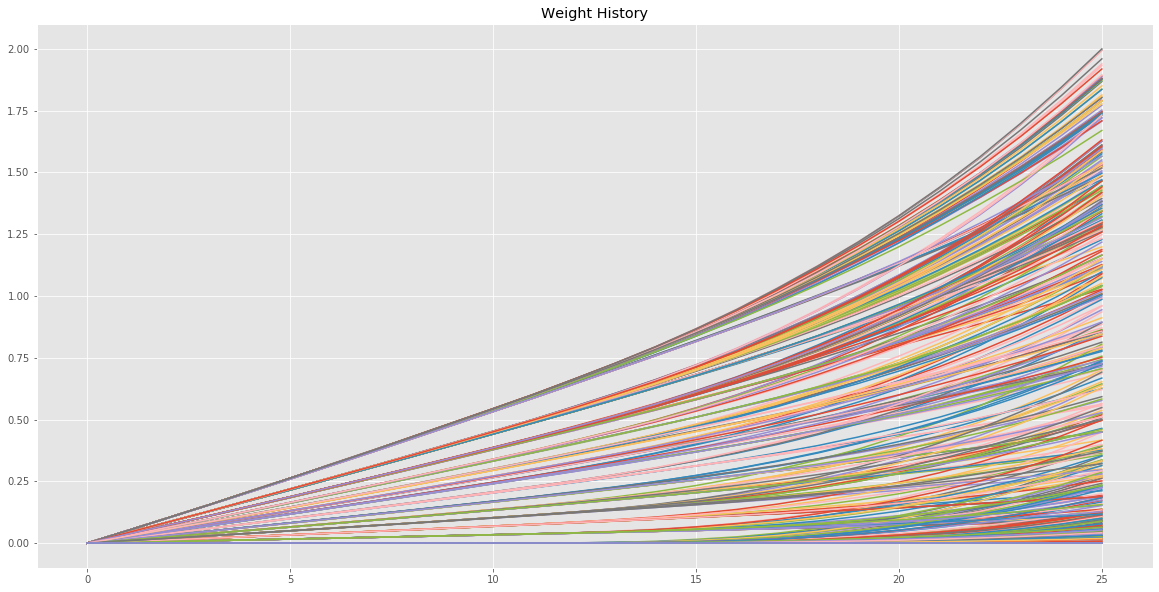

input set: 0
	input 0: 0.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 6250.0 spikes/1.0s
	input 3: 16650.0 spikes/1.0s
	input 4: 11100.0 spikes/1.0s
	input 5: 1250.0 spikes/1.0s
	input 6: 0.0 spikes/1.0s
	input 7: 0.0 spikes/1.0s
	input 8: 0.0 spikes/1.0s
	input 9: 0.0 spikes/1.0s
	input 10: 16650.0 spikes/1.0s
	input 11: 16650.0 spikes/1.0s
	input 12: 12500.0 spikes/1.0s
	input 13: 16650.0 spikes/1.0s
	input 14: 6250.0 spikes/1.0s
	input 15: 0.0 spikes/1.0s
	input 16: 0.0 spikes/1.0s
	input 17: 3800.0 spikes/1.0s
	input 18: 16650.0 spikes/1.0s
	input 19: 2550.0 spikes/1.0s
	input 20: 0.0 spikes/1.0s
	input 21: 14250.0 spikes/1.0s
	input 22: 10000.0 spikes/1.0s
	input 23: 0.0 spikes/1.0s
	input 24: 0.0 spikes/1.0s
	input 25: 5000.0 spikes/1.0s
	input 26: 14250.0 spikes/1.0s
	input 27: 0.0 spikes/1.0s
	input 28: 0.0 spikes/1.0s
	input 29: 10000.0 spikes/1.0s
	input 30: 10000.0 spikes/1.0s
	input 31: 0.0 spikes/1.0s
	input 32: 0.0 spikes/1.0s
	input 33: 6250.0 spikes/1.0s
	input 34:

	input 29: 1250.0 spikes/1.0s
	input 30: 0.0 spikes/1.0s
	input 31: 0.0 spikes/1.0s
	input 32: 0.0 spikes/1.0s
	input 33: 0.0 spikes/1.0s
	input 34: 0.0 spikes/1.0s
	input 35: 1250.0 spikes/1.0s
	input 36: 14250.0 spikes/1.0s
	input 37: 14250.0 spikes/1.0s
	input 38: 1250.0 spikes/1.0s
	input 39: 0.0 spikes/1.0s
	input 40: 0.0 spikes/1.0s
	input 41: 0.0 spikes/1.0s
	input 42: 0.0 spikes/1.0s
	input 43: 0.0 spikes/1.0s
	input 44: 1250.0 spikes/1.0s
	input 45: 12500.0 spikes/1.0s
	input 46: 10000.0 spikes/1.0s
	input 47: 0.0 spikes/1.0s
	input 48: 0.0 spikes/1.0s
	input 49: 0.0 spikes/1.0s
	input 50: 10000.0 spikes/1.0s
	input 51: 5000.0 spikes/1.0s
	input 52: 6250.0 spikes/1.0s
	input 53: 16650.0 spikes/1.0s
	input 54: 11100.0 spikes/1.0s
	input 55: 0.0 spikes/1.0s
	input 56: 0.0 spikes/1.0s
	input 57: 0.0 spikes/1.0s
	input 58: 9050.0 spikes/1.0s
	input 59: 16650.0 spikes/1.0s
	input 60: 16650.0 spikes/1.0s
	input 61: 11100.0 spikes/1.0s
	input 62: 0.0 spikes/1.0s
	input 63: 0.0 spikes

	output 0: 550.0 spikes/1.0s, confidence: 0.07051282051282051
	output 1: 950.0 spikes/1.0s, confidence: 0.12179487179487179
	output 2: 900.0 spikes/1.0s, confidence: 0.11538461538461539
	output 3: 550.0 spikes/1.0s, confidence: 0.07051282051282051
	output 4: 650.0 spikes/1.0s, confidence: 0.08333333333333333
	output 5: 900.0 spikes/1.0s, confidence: 0.11538461538461539
	output 6: 1050.0 spikes/1.0s, confidence: 0.1346153846153846
	output 7: 450.0 spikes/1.0s, confidence: 0.057692307692307696
	output 8: 1000.0 spikes/1.0s, confidence: 0.1282051282051282
	output 9: 800.0 spikes/1.0s, confidence: 0.10256410256410256

input set: 7
	input 0: 0.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 9050.0 spikes/1.0s
	input 3: 10000.0 spikes/1.0s
	input 4: 16650.0 spikes/1.0s
	input 5: 20000.0 spikes/1.0s
	input 6: 16650.0 spikes/1.0s
	input 7: 1250.0 spikes/1.0s
	input 8: 0.0 spikes/1.0s
	input 9: 0.0 spikes/1.0s
	input 10: 9050.0 spikes/1.0s
	input 11: 9050.0 spikes/1.0s
	input 12: 5000.0 spike

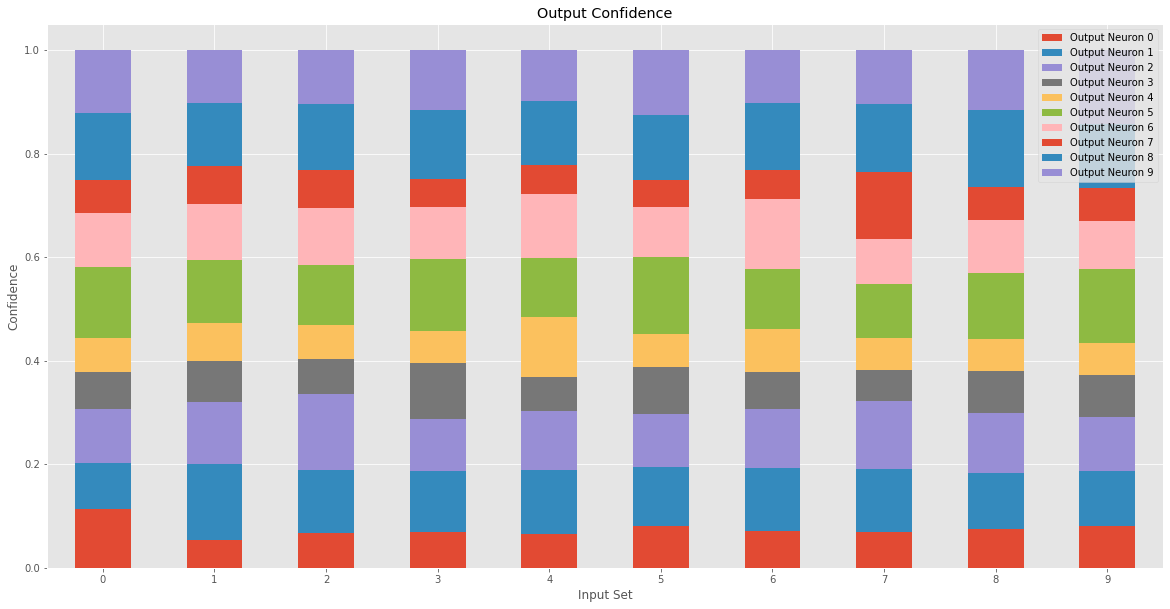

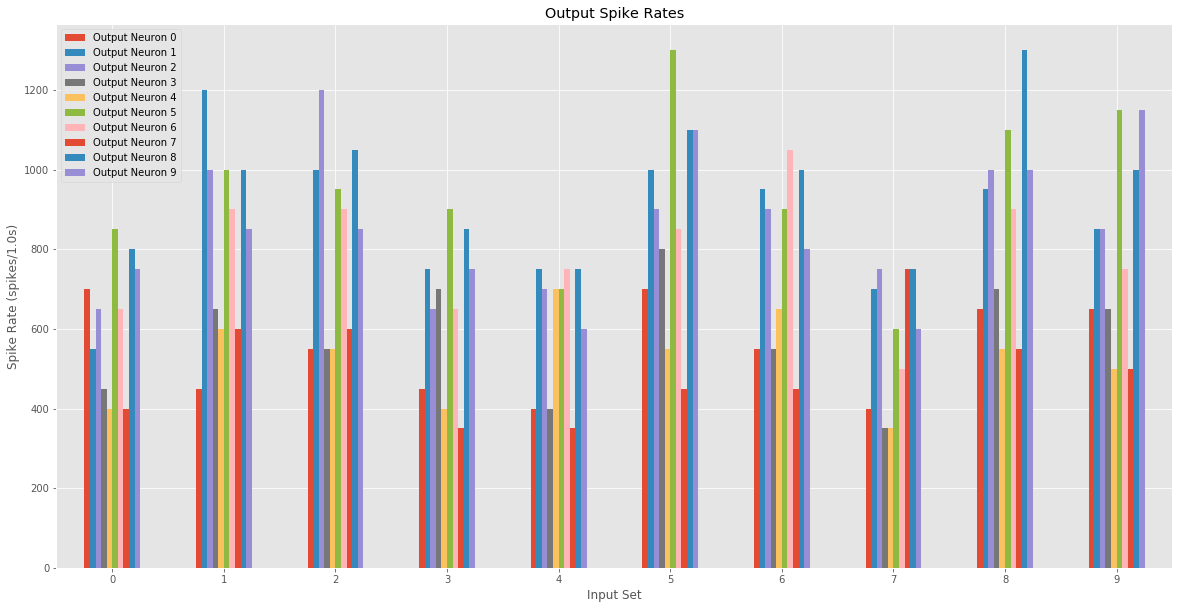

In [8]:
digits = load_digits()

u_t = 2000 # units of time
t_a = 1000 # training injection amount
s_a = -100 # training supression amount

input_limit = 10
pixels_per_digit = len(digits.data[0])
intensity_multiplier = 500
digit_types = 10 # max: 10, min: 1

# preprocess data
inputs = np.zeros((input_limit, pixels_per_digit, u_t), float)
trainings = np.zeros((input_limit, digit_types, u_t), float)

for i, (digit, target) in enumerate(zip(digits.data[:input_limit], digits.target[:input_limit])):
    digit_voltage_stream = np.zeros((pixels_per_digit, u_t), float)
    training_voltage_stream = np.zeros((digit_types, u_t), float)
    
    for j, pixel in enumerate(digit):
        digit_voltage_stream[j] = np.array([pixel * intensity_multiplier] * u_t)
         
    assert target < digit_types
    for j in range(digit_types):
        training_voltage_stream[j] = np.array([t_a] * u_t) if j == target else np.array([s_a] * u_t)
        
    inputs[i] = digit_voltage_stream
    trainings[i] = training_voltage_stream

weights = np.zeros((pixels_per_digit, digit_types))
    
# feed into network
digit_network = SingleLayerSNN(inputs=inputs, weights=weights, trainings=trainings)
digit_network.train(epochs=25, a_corr=0.000000001, w_max=2.0, w_decay=0.0, show_legend=False)

# predict the first 10 images in the dataset
digit_network.predict(inputs[:10], bar_width=0.1);


In [ ]:
a = np.array([1, 2, 3, 4])
b = np.array([1, 2])
b = np.pad(b, (0, len(a) - len(b)), "constant")
c = [2, 3, 5]

shuffled, order = shuffle_forward(a)
print('shuffled:', shuffled)
unshuffled = shuffle_backward(shuffled, order)
print('unshuffled:', unshuffled)


In [ ]:
np.repeat([[1],[2],[3]], 4, axis=1)